# Entrenamiento y predicción con BigQuery ML

## Introducción

Este tutorial muestra cómo entrenar y evaluar un modelo de clasificación binaria con BQML. También usaremos este modelo para generar predicciones.

Las dos primeras partes del tutorial explican cómo extraer los datos y prepararlos antes de entrenar su modelo.

La última parte del tutorial profundiza en el código de entrenamiento que se usa para este modelo, con un enfoque particular en los requisitos para hacerlo compatible con BigQuery ML.

## Conjunto de Datos

Este tutorial utiliza el conjunto de datos de ingresos del censo de los Estados Unidos proporcionado por el repositorio de aprendizaje automático de UC Irvine. Este conjunto de datos contiene información sobre personas de una base de datos del Censo de 1994, incluida la edad, la educación, el estado civil, la ocupación y si ganan más de $50,000 al año.

El conjunto de datos ahora existe en los conjuntos de datos públicos de BigQuery:

`bigquery-public-data.ml_datasets.census_adult_income`

## Meta

El objetivo es entrenar un modelo de clasificación binaria con BigQuery ML que prediga si una persona gana más de $50,000 al año (etiqueta de destino) en función de otra información del censo sobre la persona (características).

## Configuración del proyecto

In [1]:
# Data processing
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# BigQuery API
from google.cloud import bigquery 

In [2]:
PROJECT = 'bq-experiments-350102'

In [3]:
import os
os.environ['PROJECT'] = PROJECT

## Flujo de trabajo con un modelo de BigQuery

In this section we will build a BQML model from scratch. We will perform the following steps:
- Data preparation
- Model creation
- Model training
- Model evaluation
- Model serving

### Importaciones

In [7]:
# Procesamiento de datos
import pandas as pd

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# BigQuery API
from google.cloud import bigquery 

# Mostrar versiones de software
print(__import__('sys').version)
print(pd.__version__)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
1.3.5


### Definir constantes

In [8]:
COLUMNS = [
    'age', 'workclass', 'functional_weight', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'
]

LABEL_COLUMN = 'income_bracket'

UNUSED_COLUMNS = ['functional_weight', 'education', 'sex']

## Preparación de datos

### Procesar columnas numéricas y categóricas
Los conjuntos de datos del censo contienen números y cadenas que necesitamos para convertir los datos de cadena en números para poder entrenar el modelo.

### BigQuery ML admite el manejo de datos categóricos:

Para todas las columnas no numéricas que no sean TIMESTAMP, BigQuery ML realiza una transformación de codificación one-hot. Esta transformación genera una característica separada para cada valor único en la columna.

### Crear cliente de BigQuery
Cree un cliente de BigQuery para agrupar la configuración necesaria para las solicitudes de API.

In [10]:
client = bigquery.Client(location='US', project=PROJECT)

### Crear conjunto de datos de BigQuery
Crearemos un conjunto de datos llamado censo_tutorial, dentro de este conjunto de datos crearemos nuestro modelo BQML. **NOTA:** solo ejecute este código una vez.

In [13]:
# Dataset and table information
dataset_name = 'census_example'

# Create BigQuery dataset
dataset = client.create_dataset(dataset_name)

## Extraiga conjuntos de datos de entrenamiento y evaluación:
En este caso, dividiremos nuestros datos en 80/10/10 para entrenamiento, validación y prueba.

Para eML, desea un muestreo repetible de los datos que tiene en BigQuery. Para obtener los datos de validación: cambie el < 8 en la consulta anterior a = 8, y para los datos de prueba, cámbielo a = 9. De esta manera, obtiene el 10 % de las muestras en validación y el 10 % en prueba.

#### Todos los datos

In [15]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
dataset = client.query(query).to_dataframe()

### Datos de entrenamiento

[Muestreo repetible](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39)

In [16]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) < 8
"""
train_dataset = client.query(query).to_dataframe()

#### Datos de evaluación

In [17]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
"""
eval_dataset = client.query(query).to_dataframe()

#### Datos de prueba

In [18]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 9
"""
test_dataset = client.query(query).to_dataframe()

#### Longitud del dataframe

Indique la longitud de los datos de entrenamiento y prueba. Esto validará que el conjunto de datos contenga datos antes de que comencemos a procesarlo.

In [19]:
len(dataset), len(train_dataset), len(eval_dataset), len(test_dataset)

(32561, 26192, 3268, 3101)

## Visualiza los datos

<AxesSubplot:>

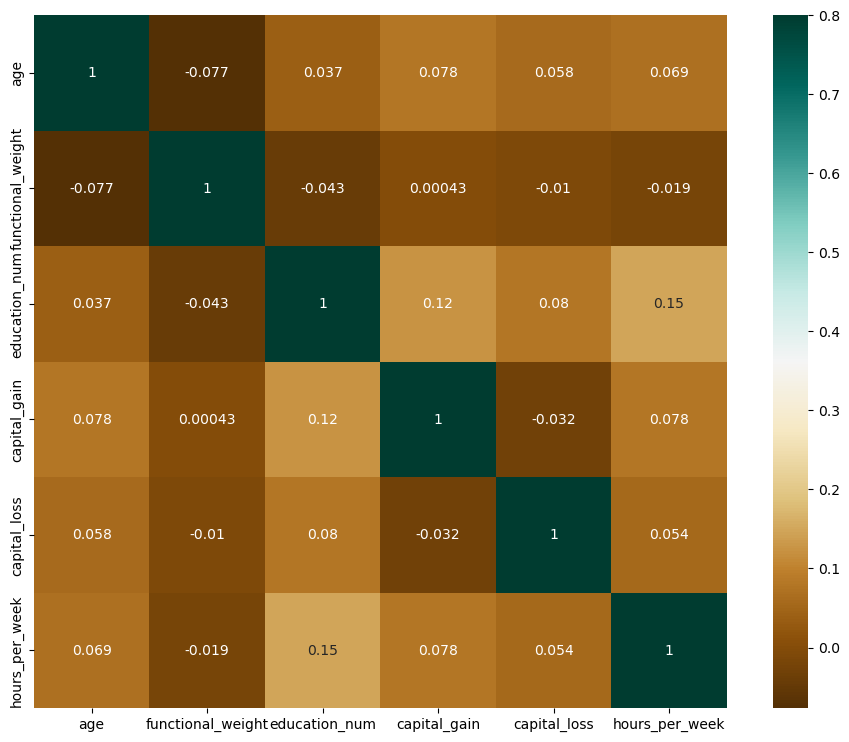

In [20]:
hmap = dataset.corr(method='pearson')
plt.subplots(figsize=(12, 9))
sns.heatmap(hmap, vmax=0.8 ,annot=True, cmap="BrBG", square=True)